In [1]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../../analysisTools/")
from skimmerTools import Skimmer
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py

### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [2]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [3]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [4]:
suffix = "_TrueVertexForSignal"

In [5]:
cut_config = "./cut_configs/preselections_BDTv2.py"

In [6]:
sig_sample_json_dir = '../'
jsons = [f for f in os.listdir(sig_sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if "skimmed_sig_v2_mA_3m1_2018_aEM_ctau-1." in samp ]
print(signal_list)

bkg_sample_json_dir = '../../../configs/sample_configs/'
jsons = [f for f in os.listdir(bkg_sample_json_dir) if ".json" in f]

bkg_list = [ samp.split('.')[0] for samp in jsons if "skimmed_bkg" in samp ]
print(bkg_list)

['skimmed_sig_v2_mA_3m1_2018_aEM_ctau-1']
['skimmed_bkg_2018_DY', 'skimmed_bkg_2018_Diboson', 'skimmed_bkg_2018_QCD_TuneCP5_PSWeights', 'skimmed_bkg_2018_TTJetsDiLept', 'skimmed_bkg_2018_Top', 'skimmed_bkg_2018_Triboson', 'skimmed_bkg_2018_WJets', 'skimmed_bkg_2018_ZJets']


In [7]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sig_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_sig_v2_mA_3m1_2018_aEM_ctau-1


Output()

Output()

Completed in 0.75 min



In [8]:
for samp in bkg_list:
    if 'TTJetsDiLept' in samp: # currently not available ntuples
        continue
    
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{bkg_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_bkg_2018_DY


Output()

Output()

Completed in 1.26 min

Start analyzing: skimmed_bkg_2018_Diboson


Output()

Output()

Completed in 0.80 min

Start analyzing: skimmed_bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Completed in 2.77 min

Start analyzing: skimmed_bkg_2018_Top


Output()

Output()

Completed in 3.90 min

Start analyzing: skimmed_bkg_2018_Triboson


Output()

Output()

Completed in 0.42 min

Start analyzing: skimmed_bkg_2018_WJets


Output()

Output()

Completed in 3.08 min

Start analyzing: skimmed_bkg_2018_ZJets


Output()

Output()

Completed in 2.36 min



## BDT

In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [8]:
h5_dir = "./h5/"
sig_suffix = "ctau-1_TrueVertexForSignal"
bkg_suffix = "_TrueVertexForSignal"

sig_files = [f for f in os.listdir(h5_dir) if sig_suffix in f and 'sig' in f]
bkg_files = [f for f in os.listdir(h5_dir) if bkg_suffix in f and 'bkg' in f]

# vtx variables
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy_signif']

sig_data = []

sig_xsec_norm = []
sig_point = {'m1':[], 'delta':[], 'ctau':[]}

for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])
        
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        
        sig_data.append(np.concatenate([fin[v][()][mask].reshape(-1,1) for v in variables],axis=1))
        sig_xsec_norm.append(fin['wgt_norm'][()][mask])
        
        sig_point['m1'].append(fin['m1'][()][mask])
        sig_point['delta'].append(fin['delta'][()][mask])
        sig_point['ctau'].append(fin['ctau'][()][mask])

sig_data = np.concatenate(sig_data,axis=0)
sig_xsec_norm = np.concatenate(sig_xsec_norm,axis=0)
sig_point['m1'] = np.concatenate(sig_point['m1'], axis=0)
sig_point['delta'] = np.concatenate(sig_point['delta'], axis=0)
sig_point['ctau'] = np.concatenate(sig_point['ctau'], axis=0)

nBkg = 0
bkg_data = []

bkg_xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])
        
        bkg_data.append(np.concatenate([fin[v][()].reshape(-1,1) for v in variables],axis=1))
        bkg_xsec_norm.append(fin['wgt_norm'][()])

bkg_xsec_norm = np.concatenate(bkg_xsec_norm,axis=0)


print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

Signal events 6322 -> 6322 after gen matching (raw counts)

DY: 9
Diboson: 767
QCD: 3
Top: 2006
Triboson: 92
WJets: 29090
ZJets: 44480

Number of total background events (raw counts): 76447


In [9]:
print('Signal input statistics (unweighted)')

sig_subprocess = {}

ctau = 1.
for delta in [0.1, 0.2]:
    for m1 in [5.,10.,20.,30.,40.,50.]:
        idx = ((sig_point['m1'] == m1) & (sig_point['delta'] == delta))&(sig_point['ctau'] == ctau)
        point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
        sig_subprocess[point] = idx
        print(f'{point}: {np.sum(idx)}')

nSamp = 0
for samp, count in sig_subprocess.items():
    if np.sum(count) != 0:
        nSamp += 1
    else:
        print(f'{samp} has zero counts')

print(f'Number of signal subprocesses with non-zero count: {nSamp}')

Signal input statistics (unweighted)
m1_5.0_delta_0.1_ctau_1.0: 193
m1_10.0_delta_0.1_ctau_1.0: 391
m1_20.0_delta_0.1_ctau_1.0: 501
m1_30.0_delta_0.1_ctau_1.0: 597
m1_40.0_delta_0.1_ctau_1.0: 717
m1_50.0_delta_0.1_ctau_1.0: 1140
m1_5.0_delta_0.2_ctau_1.0: 220
m1_10.0_delta_0.2_ctau_1.0: 405
m1_20.0_delta_0.2_ctau_1.0: 556
m1_30.0_delta_0.2_ctau_1.0: 769
m1_40.0_delta_0.2_ctau_1.0: 752
m1_50.0_delta_0.2_ctau_1.0: 81
Number of signal subprocesses with non-zero count: 12


## Reweight Backgrounds

### Background raw counts

In [10]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])

        bkg_raw[process] = entries

DY: 9
Diboson: 767
QCD: 3
Top: 2006
Triboson: 92
WJets: 29090
ZJets: 44480


### Cutflow counts (xsec weighted)

In [11]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = sum(fin['wgt_norm'][()])
        print(f'{process}: {entries}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts}')

DY: 455.6547508239746
Diboson: 189.35027223825455
QCD: 632.250424861908
Top: 294.0013522002846
Triboson: 2.0868917726911604
WJets: 11204.390249389457
ZJets: 6256.761405692319
Total background counts (xsec weighted): 19034.49534697889


### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`

Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct.

In [12]:
sf = {}
xsec_norm = {}

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = fin['wgt_norm'][()] / total_bkg_cts * nBkg
        #print(f'{process}: {entries}')

        sf[process] = entries
        xsec_norm[process] = fin['wgt_norm'][()]

**With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now.**

In [13]:
total_weighted = 0

for process in sf.keys():
    print(f'{process}: {sum(sf[process])}')
    total_weighted += sum(sf[process])

print(total_weighted)

DY: 1830.0163174034096
Diboson: 760.4751062962587
QCD: 2539.266046933393
Top: 1180.7783581768153
Triboson: 8.381446863224525
WJets: 44999.45869872773
ZJets: 25128.620790256326
76446.99676465715


In [14]:
nBkg

76447

In [15]:
# SF
bkg_sf = []
bkg_xsec_norm = []

for process in sf.keys():
    bkg_sf += list(sf[process])
    bkg_xsec_norm += list(xsec_norm[process])

#print(len(bkg_sf))

In [16]:
set(bkg_xsec_norm)

{-0.05953975,
 -0.045444746,
 -0.016287146,
 -0.012563892,
 -0.0042385785,
 0.00075470324,
 0.0012511426,
 0.0042385785,
 0.004238579,
 0.01063748,
 0.012563892,
 0.016287146,
 0.024323996,
 0.028713468,
 0.030013198,
 0.037092578,
 0.038779505,
 0.039841752,
 0.043379143,
 0.045444746,
 0.05953975,
 0.08565486,
 0.18472649,
 0.19808361,
 0.2163429,
 0.2441929,
 0.2524531,
 0.29107392,
 0.34455764,
 0.3913622,
 0.55844516,
 1.1887455,
 2.7895231,
 7.842954,
 24.090977,
 143.50896,
 312.20374}

In [17]:
len(bkg_sf)

76447

## Reweight Signal

For signal, we also apply the reweighting factors.
1) First, since our signal samples are smaller than background samples, get the overall scale factor for signal samples to match the total number of background samples. Reweigh against background.
2) Then, reweigh across signal samples. We will make all signal subprocesses "equally shown" to the BDT. Currently the inputs are biased, i.e. to have more 10% splitting, 1mm ctau, etc. We will flatten these out.

In [18]:
bkg_to_sig = len(bkg_xsec_norm)/len(sig_xsec_norm)

print(f'Signal sample size (all subprocesses summed): {len(sig_xsec_norm)}')
print(f'Background sample size (all subprocesses summed): {len(bkg_xsec_norm)}')
print(f'{bkg_to_sig} more background than signal samples')

Signal sample size (all subprocesses summed): 6322
Background sample size (all subprocesses summed): 76447
12.092217652641569 more background than signal samples


In [19]:
print(f'There are {nSamp} subprocesses in signal, i.e. per m1/delta/ctau points.')
print(f'\nIdeally, sig and bkg sample size for BDT input should be the same.')
print(f'\nFor background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.')
print(f'This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.')
print(f'\nFor signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.')
print(f'But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.')
print(f'For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.')

There are 12 subprocesses in signal, i.e. per m1/delta/ctau points.

Ideally, sig and bkg sample size for BDT input should be the same.

For background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.
This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.

For signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.
But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.
For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.


In [20]:
print(f'This means, for each one of {nSamp} signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = {len(bkg_xsec_norm)/nSamp}')

This means, for each one of 12 signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = 6370.583333333333


In [21]:
print(f'We will get the SF for each signal subprocess such that their weighted count corresponds to {len(bkg_xsec_norm)/nSamp}')

We will get the SF for each signal subprocess such that their weighted count corresponds to 6370.583333333333


In [22]:
sig_sf = np.zeros(len(sig_xsec_norm)) # initialize

nSubprocessWeighted = len(bkg_xsec_norm)/nSamp
#nSubprocessWeighted = nSamp

for samp, idx in sig_subprocess.items():
    samp_idx = np.nonzero(idx)[0]
    nSubprocess = np.sum(idx) # unweighted
    if nSubprocess == 0:
        continue
    sf = nSubprocessWeighted/nSubprocess

    sig_sf[samp_idx] = sf

print(sig_sf)

[78.64917695 78.64917695 78.64917695 ... 16.293052   16.293052
 16.293052  ]


In [23]:
type(sig_sf)

numpy.ndarray

### Train

In [24]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = sig_sf

In [25]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=0.8, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=0.8, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=0.8, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=0.8, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=0.8, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [69]:
test_ctau[np.where(y_test == 1)] # signal

array([1., 1., 1., ..., 1., 1., 1.])

In [70]:
test_ctau[np.where(y_test == 0)] # bkg; should all be zeros by construction, printing out to check if this is the case (not messed up by random_state)

array([0., 0., 0., ..., 0., 0., 0.])

In [71]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)
#bst.fit(train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [72]:
# make predictions
preds = bst.predict(test)

In [73]:
os.system('mkdir -p plots')

0

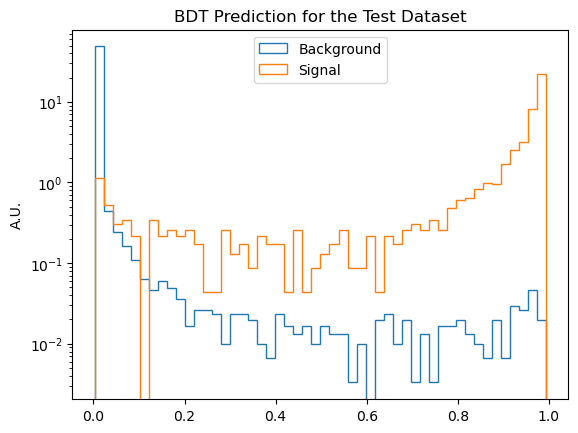

In [74]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
plt.savefig('plots/BDTv2_ctau-1_score.png')
plt.yscale('log')

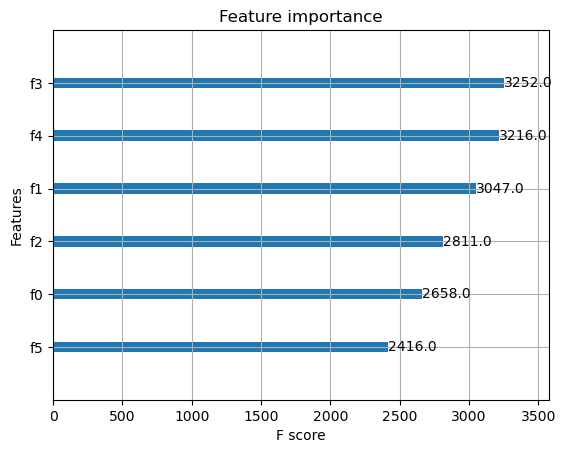

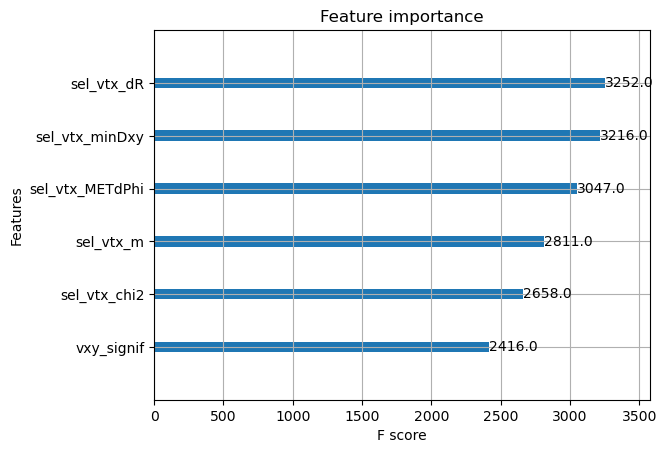

In [75]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
plt.savefig('plots/BDTv2_ctau-1_importance_bst.png', bbox_inches = "tight")

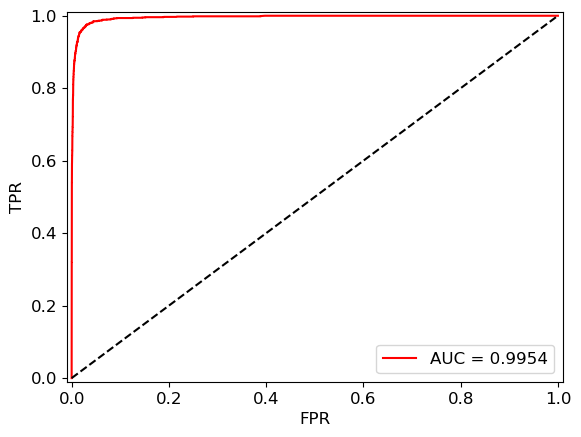

In [76]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
plt.savefig('plots/BDTv2_ctau-1_roc_curve.png')

### Save and load

In [77]:
bst.save_model('models/BDTv2_ctau-1_5to50.json')

In [2]:
trained_model = xgb.XGBRegressor()
trained_model.load_model("models/BDTv2_ctau-1_5to50.json")

In [26]:
prediction = trained_model.predict(test)

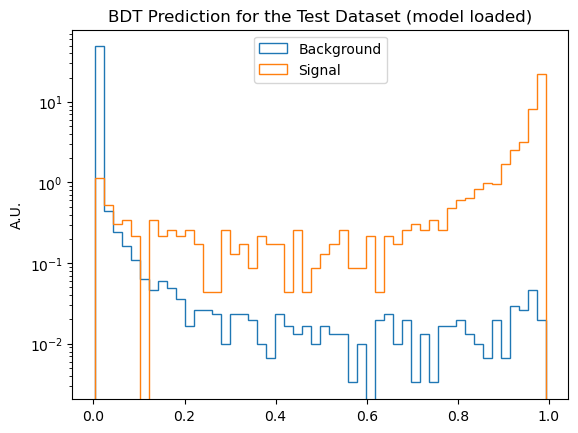

In [29]:
bins = 50

h_bkg,bins,_ = plt.hist(prediction[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h_sig,bins,_ = plt.hist(prediction[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset (model loaded)')

plt.ylabel('A.U.')
plt.yscale('log')

In [46]:
h_sig = h_sig[::-1]
h_sig

array([22.02289376,  8.09094996,  3.15848967,  2.5094925 ,  1.68741229,
        0.95187647,  0.99514058,  0.82207513,  0.64900473,  0.60573957,
        0.4759368 ,  0.25960267,  0.34613585,  0.25960267,  0.30286887,
        0.25960267,  0.17306793,  0.21633556,  0.04326698,  0.21633556,
        0.08653396,  0.08653422,  0.25960189,  0.17306845,  0.12980114,
        0.08653409,  0.04326698,  0.25960228,  0.04326705,  0.17306819,
        0.17306819,  0.21633523,  0.08653409,  0.17306819,  0.12980114,
        0.25960228,  0.04326705,  0.04326708,  0.17306819,  0.25960209,
        0.21633523,  0.25960228,  0.21633523,  0.34613651,  0.        ,
        0.21633515,  0.34613638,  0.30286939,  0.51920451,  1.12494319])

In [47]:
h_bkg = h_bkg[::-1]
h_bkg

array([1.98139573e-02, 4.62327061e-02, 2.64186097e-02, 2.97210254e-02,
       6.60465243e-03, 1.98140169e-02, 6.60465243e-03, 9.90700846e-03,
       1.32093049e-02, 1.98140169e-02, 1.65116311e-02, 1.65116808e-02,
       3.30232621e-03, 1.32093446e-02, 3.30232621e-03, 1.98140169e-02,
       9.90697864e-03, 2.31163531e-02, 1.98139573e-02, 0.00000000e+00,
       9.90697864e-03, 3.30233615e-03, 1.32093049e-02, 1.32093446e-02,
       1.65116559e-02, 9.90699355e-03, 1.65116311e-02, 1.32093247e-02,
       1.65116559e-02, 2.31163183e-02, 6.60466237e-03, 9.90699355e-03,
       1.98139871e-02, 2.31163183e-02, 2.31163183e-02, 9.90699355e-03,
       2.31163183e-02, 2.64186693e-02, 2.64186495e-02, 1.65116435e-02,
       3.63256430e-02, 4.95349678e-02, 5.94419613e-02, 4.62326540e-02,
       6.27442925e-02, 1.08976888e-01, 1.65116559e-01, 2.41070222e-01,
       4.39210006e-01, 4.86400360e+01])

In [48]:
# S/B scan on the score (xsec unweighted)
h_sig_sum = []
h_bkg_sum = []

for idx, entry in enumerate(h_sig):
    integral = 0
    for j in range(idx):
        integral += h_sig[j]
    h_sig_sum.append(integral)

for idx, entry in enumerate(h_bkg):
    integral = 0
    for j in range(idx):
        integral += h_bkg[j]
    h_bkg_sum.append(integral)

np.array(h_sig_sum)/np.array(h_bkg_sum)

/tmp/ipykernel_11025/326739833.py:17: RuntimeWarning: invalid value encountered in divide
  np.array(h_sig_sum)/np.array(h_bkg_sum)


array([          nan, 1111.48386175,  455.94799425,  359.83599314,
        292.84646744,  290.93067415,  258.54529092,  253.95497493,
        243.69641425,  229.28429007,  209.41296567,  195.52155705,
        182.67874271,  181.58208308,  172.94585328,  171.87701241,
        160.25931408,  155.21967579,  144.12153508,  135.43147722,
        136.0999459 ,  132.31682498,  131.27650134,  127.06429939,
        122.92020961,  117.91764452,  115.14180632,  110.5677729 ,
        107.70431462,  103.72386376,   98.87739575,   97.84656678,
         96.26302643,   92.58719888,   88.79291593,   85.24264508,
         84.18206971,   80.87073384,   77.38796308,   74.40535395,
         72.90066325,   69.32591882,   64.97624982,   60.35674133,
         57.43113342,   53.41940028,   47.85438514,   41.4095869 ,
         34.56102058,   26.64766671])

[Text(0, 0, 'vxy_signif'),
 Text(0, 1, 'sel_vtx_chi2'),
 Text(0, 2, 'sel_vtx_m'),
 Text(0, 3, 'sel_vtx_METdPhi'),
 Text(0, 4, 'sel_vtx_minDxy'),
 Text(0, 5, 'sel_vtx_dR')]

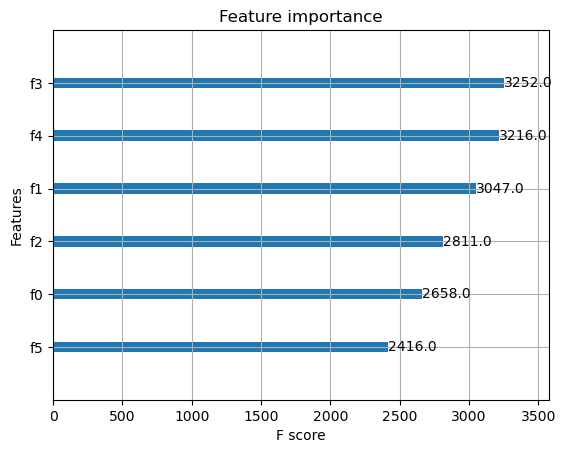

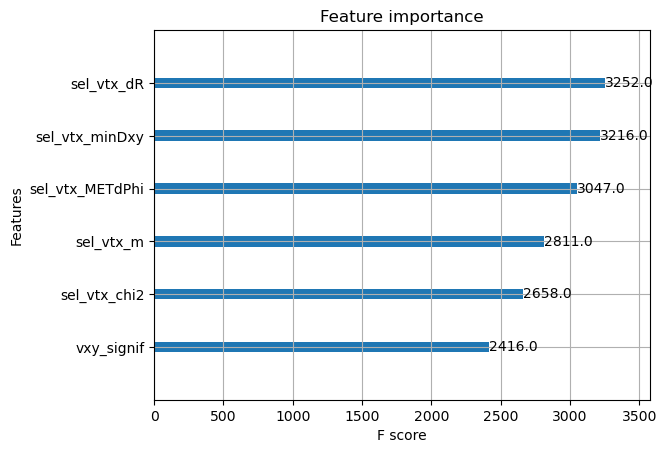

In [81]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(trained_model)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(trained_model).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

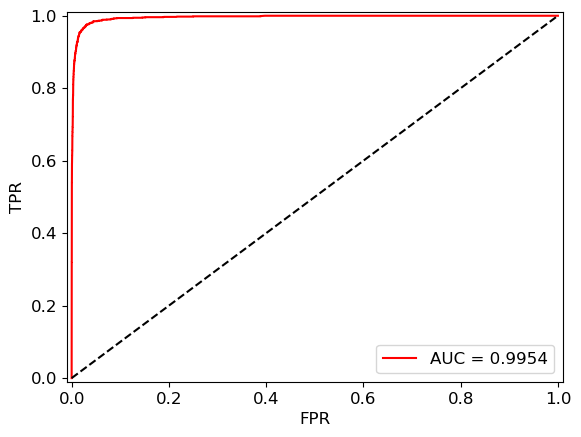

In [82]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
precision, recall, thresholds2 = precision_recall_curve(y_test, prediction)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### WP

In [83]:
idx_valid = thresholds < 1

tpr = tpr[idx_valid]
thresholds = thresholds[idx_valid]

In [84]:
tpr_WP = {'tight': 0.7, 'medium': 0.8, 'loose': 0.9}
thres_WP = {'tight': 0, 'medium': 0, 'loose': 0}

In [85]:
epsilon = 0.015

for wp in tpr_WP.keys():    
    idx = np.where((tpr > tpr_WP[wp] - epsilon) & (tpr < tpr_WP[wp] + epsilon))
    
    thres_WP[wp] = thresholds[idx].mean()

    print(f'{wp} threshold: {thres_WP[wp]}')

tight threshold: 0.9303873181343079
medium threshold: 0.8505542278289795
loose threshold: 0.4690726101398468


### TPR

In [86]:
# BDT scores for the signal
nPass_sig = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    nPass_sig[wp] = np.sum(preds[np.where(y_test==1)] > thres_WP[wp])
    nPass_bkg[wp] = np.sum(preds[np.where(y_test==0)] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig[wp]} / {len(preds[np.where(y_test==1)])} = {nPass_sig[wp]/len(preds[np.where(y_test==1)])}')
    print(f'FPR: {nPass_bkg[wp]} / {len(preds[np.where(y_test==0)])} = {nPass_bkg[wp]/len(preds[np.where(y_test==0)])}')


tight pass
TPR: 881 / 1265 = 0.6964426877470355
FPR: 33 / 15290 = 0.002158273381294964

medium pass
TPR: 1013 / 1265 = 0.8007905138339921
FPR: 48 / 15290 = 0.0031393067364290385

loose pass
TPR: 1135 / 1265 = 0.8972332015810277
FPR: 120 / 15290 = 0.007848266841072597


In [87]:
# for a given point
m1 = 30.
delta = 0.1
ctau = 1.

nPass_sig_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
    bkg_idx = np.where(y_test==0)
    
    nPass_sig_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
    nPass_bkg_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig_sigpoint[wp]} / {len(preds[sig_idx])} = {nPass_sig_sigpoint[wp]/len(preds[sig_idx])}')
    print(f'FPR: {nPass_bkg_sigpoint[wp]} / {len(preds[bkg_idx])} = {nPass_bkg_sigpoint[wp]/len(preds[bkg_idx])}')


tight pass
TPR: 92 / 127 = 0.7244094488188977
FPR: 33 / 15290 = 0.002158273381294964

medium pass
TPR: 103 / 127 = 0.8110236220472441
FPR: 48 / 15290 = 0.0031393067364290385

loose pass
TPR: 116 / 127 = 0.9133858267716536
FPR: 120 / 15290 = 0.007848266841072597


### TPR per signal point

In [88]:
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [1.]:
    for delta in [0.1, 0.2]:
        for m1 in [5., 10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])

                if len(sig_idx[0]) == 0:
                    tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(0)
                    continue
                
                print(f'm1 = {m1}, delta = {delta}, ct = {ctau}')
                print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')

                tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(nPass_sig_raw_sigpoint[wp]/len(sig_idx[0]))

m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 20 / 39 = 0.5128205128205128
m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 28 / 39 = 0.717948717948718
m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 37 / 39 = 0.9487179487179487
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 54 / 75 = 0.72
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 62 / 75 = 0.8266666666666667
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 74 / 75 = 0.9866666666666667
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 63 / 88 = 0.7159090909090909
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 73 / 88 = 0.8295454545454546
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 83 / 88 = 0.9431818181818182
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 92 / 127 = 0.7244094488188977
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 103 / 127 = 0.8110236220472441
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 116 / 127 = 0.9133858267716536
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 105 / 147 = 0.7142857142857143
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 120 / 147 = 0.8163265306122449
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 133 / 147 = 0.9047619047619048
m1

In [89]:
tpr_raw

{'0.1': {'ct-1': {'tight': [0.5128205128205128,
    0.72,
    0.7159090909090909,
    0.7244094488188977,
    0.7142857142857143,
    0.6367521367521367],
   'medium': [0.717948717948718,
    0.8266666666666667,
    0.8295454545454546,
    0.8110236220472441,
    0.8163265306122449,
    0.7264957264957265],
   'loose': [0.9487179487179487,
    0.9866666666666667,
    0.9431818181818182,
    0.9133858267716536,
    0.9047619047619048,
    0.811965811965812]},
  'ct-10': {'tight': [], 'medium': [], 'loose': []},
  'ct-100': {'tight': [], 'medium': [], 'loose': []}},
 '0.2': {'ct-1': {'tight': [0.75,
    0.6987951807228916,
    0.8454545454545455,
    0.7123287671232876,
    0.6556291390728477,
    0.47058823529411764],
   'medium': [0.875,
    0.8674698795180723,
    0.8818181818181818,
    0.8493150684931506,
    0.7417218543046358,
    0.5882352941176471],
   'loose': [0.9583333333333334,
    0.9518072289156626,
    0.9545454545454546,
    0.9315068493150684,
    0.8013245033112583,
  

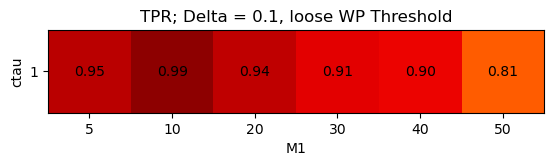

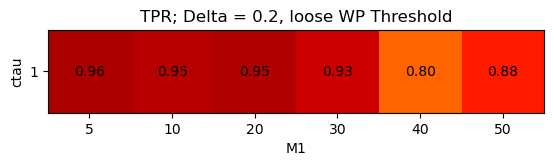

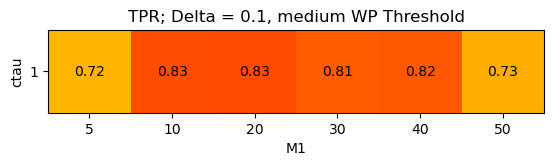

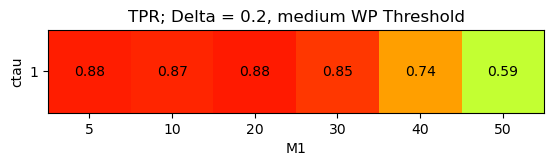

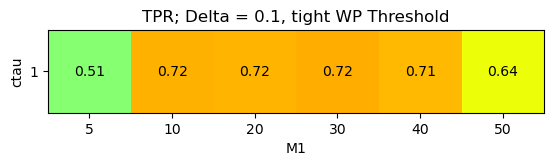

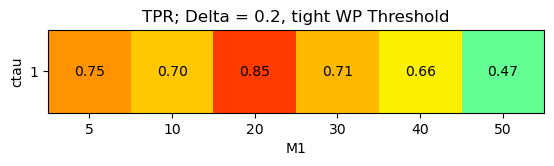

In [90]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-1'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [1])
        plt.gca().invert_yaxis()
        
        plt.show()

### TPR on half dataset (not just 20%)

In [52]:
train_size = 0.5

sig_train, sig_test = train_test_split(sig_data,train_size=train_size,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=train_size, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=train_size, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=train_size, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=train_size, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=train_size, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=train_size,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=train_size, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=train_size, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

#perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

#perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [53]:
preds = bst.predict(test)

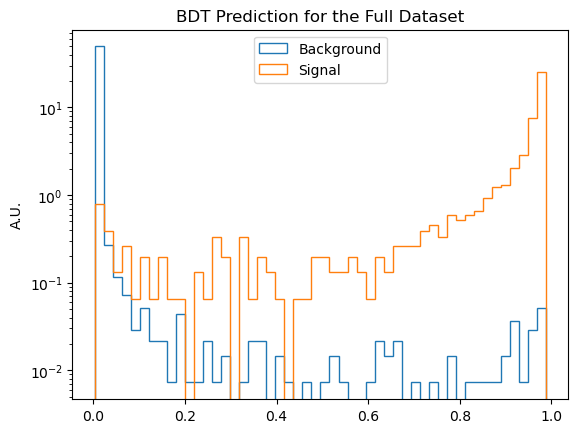

In [54]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Full Dataset')

plt.ylabel('A.U.')
#plt.savefig('plots/BDTscore.png')
plt.yscale('log')

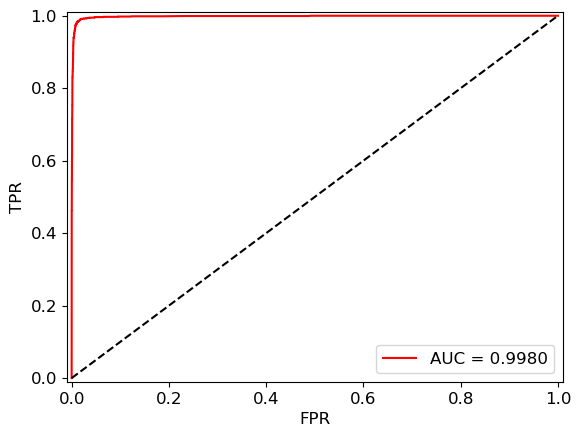

In [55]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

In [56]:
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [1.]:
    for delta in [0.1, 0.2]:
        for m1 in [5., 10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])

                if len(sig_idx[0]) == 0:
                    tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(0)
                    continue
                
                print(f'm1 = {m1}, delta = {delta}, ct = {ctau}')
                print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')

                tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(nPass_sig_raw_sigpoint[wp]/len(sig_idx[0]))

m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 35 / 47 = 0.7446808510638298
m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 44 / 47 = 0.9361702127659575
m1 = 5.0, delta = 0.1, ct = 1.0
TPR: 45 / 47 = 0.9574468085106383
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 74 / 109 = 0.6788990825688074
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 88 / 109 = 0.8073394495412844
m1 = 10.0, delta = 0.1, ct = 1.0
TPR: 103 / 109 = 0.944954128440367
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 93 / 123 = 0.7560975609756098
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 108 / 123 = 0.8780487804878049
m1 = 20.0, delta = 0.1, ct = 1.0
TPR: 118 / 123 = 0.959349593495935
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 102 / 140 = 0.7285714285714285
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 115 / 140 = 0.8214285714285714
m1 = 30.0, delta = 0.1, ct = 1.0
TPR: 129 / 140 = 0.9214285714285714
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 129 / 192 = 0.671875
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 148 / 192 = 0.7708333333333334
m1 = 40.0, delta = 0.1, ct = 1.0
TPR: 177 / 192 = 0.921875

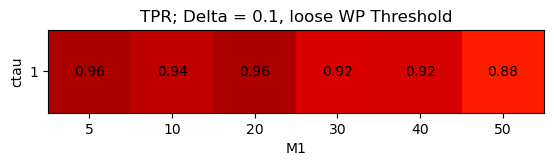

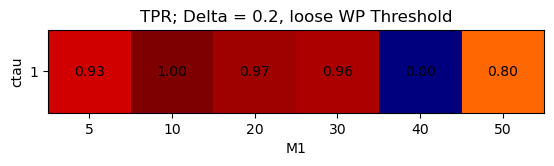

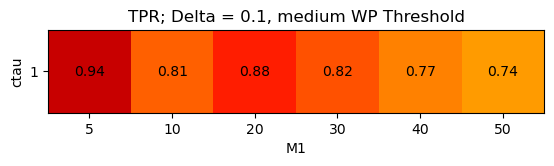

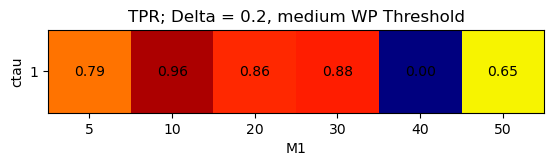

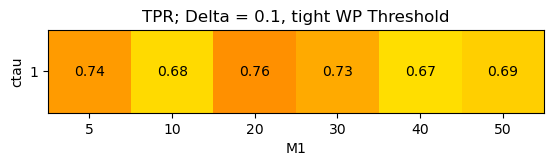

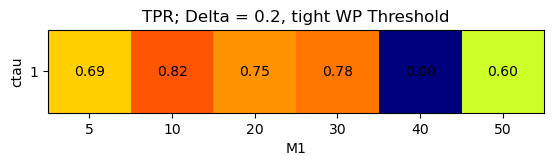

In [57]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-1'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [1])
        plt.gca().invert_yaxis()
        
        plt.show()

### Pearson Correlation Coefficient

In [45]:
import pandas as pd

df_bkg = pd.DataFrame(bkg_data, columns = variables)
df_sig = pd.DataFrame(sig_data, columns = variables)
df_all = pd.DataFrame(np.concatenate((bkg_data,sig_data),axis=0), columns = variables)

In [46]:
corr_all = df_all.corr()
corr_bkg = df_bkg.corr()
corr_sig = df_sig.corr()

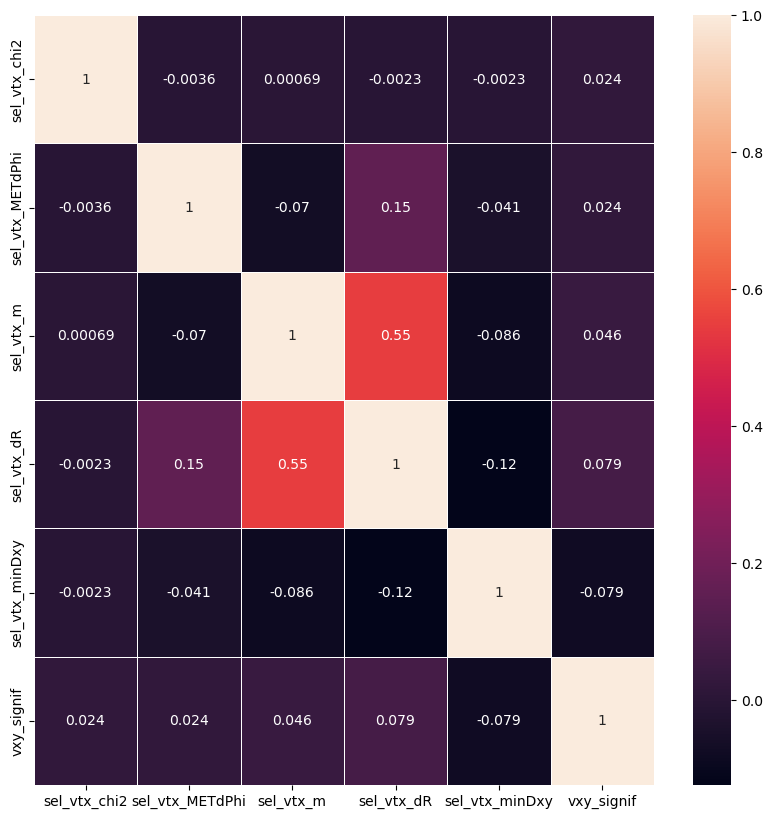

In [47]:
import seaborn as sb
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_all, annot=True, linewidths=.5)

Text(0.5, 1.0, 'PCC in Background Samples (Dataset size: 76447)')

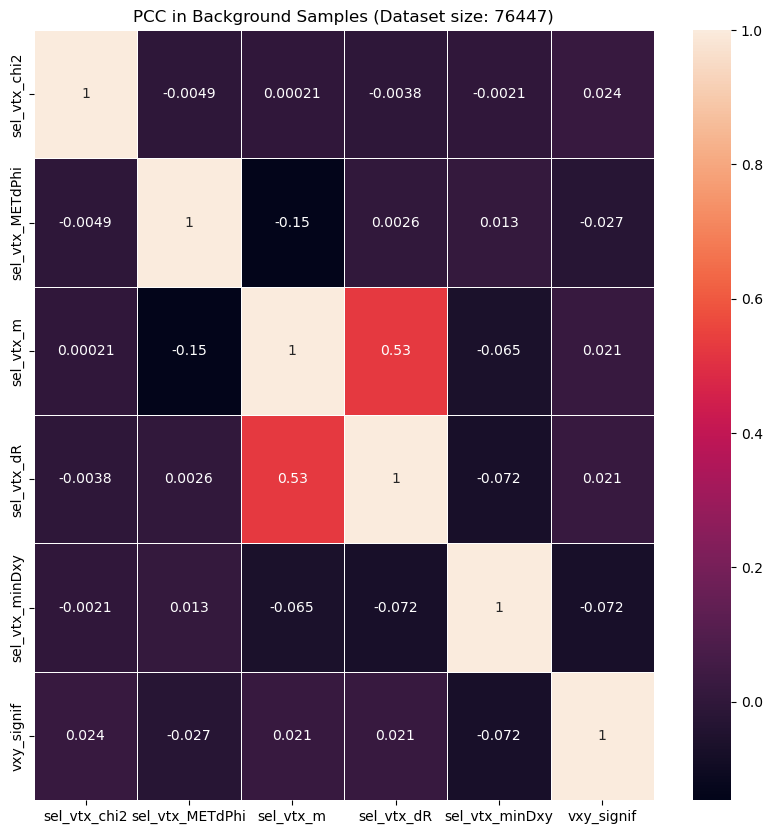

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_bkg, annot=True, linewidths=.5)
plt.title(f'PCC in Background Samples (Dataset size: {bkg_data.shape[0]})') # Unweighted by xsec

Text(0.5, 1.0, 'PCC in Signal Samples (Dataset size: 6322)')

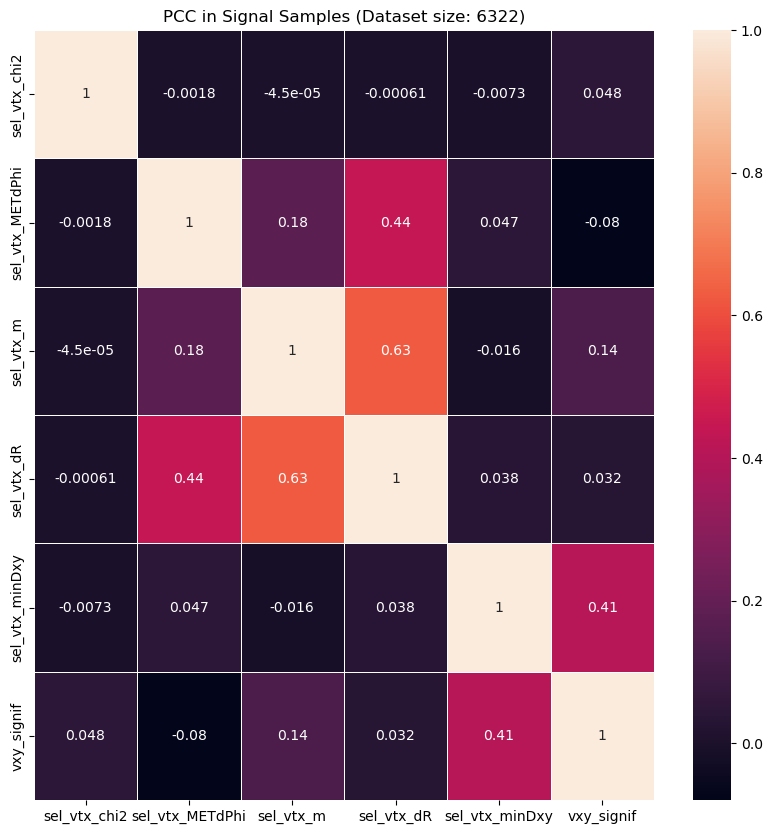

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_sig, annot=True, linewidths=.5)
plt.title(f'PCC in Signal Samples (Dataset size: {sig_data.shape[0]})')